In [1]:
import numpy as np
import pandas as pd
import json
from pandas.io.json import json_normalize
import requests

import imageio
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

In [2]:
#USPTO Trademark Document Search (v1)
r = requests.get('https://developer.uspto.gov/ibd-api/v1/trademark/documents?text=cat%20three%20gears&classCode=020&start=0&rows=10')

In [3]:
#Explore the response JSON
resp = r.json()
resp_list = resp['response']['docs']
print(resp_list[0].keys())
print(resp_list[3]['uspto_tm_document']['trademark_case_files']['trademark_case_file']['case_file_header']['mark'].keys())

[u'tsdrImageLarge', u'tsdrImageOriginal', u'tsdrImageTiny', u'archiveUrl', u'uspto_tm_document', u'tsdrPdfBundle', u'_version_', u'tsdrZipBundle', u'id', u'tsdrStatusUrl']
[u'action_code', u'version', u'typed_mark']


In [4]:
serial_nos = []
for i, app in enumerate(resp_list):
    cfh = app['uspto_tm_document']['trademark_case_files']['trademark_case_file']['case_file_header']
    if 'design_mark' in cfh['mark'].keys():
        #print(i)
        serial_nos.append(cfh['serial_number'])
print(serial_nos)

[87368206, 87434394, 87928270, 87410724]


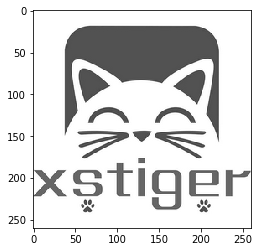

In [5]:
#Retrieve design mark image file
url_base = 'https://tsdr.uspto.gov/img/%s/large' % str(serial_nos[1])

tm_image = imageio.imread(url_base)
imshow(tm_image)

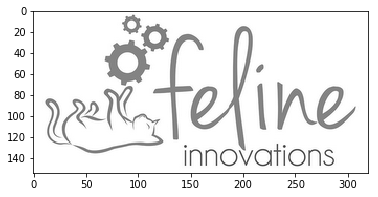

In [6]:
#Calculate L1 norm [CREATE FUNCTION]

url_base2 = 'https://tsdr.uspto.gov/img/%s/large' % str(serial_nos[0])
tm_image2 = imageio.imread(url_base2)
imshow(tm_image2)

In [7]:
tm_image2.shape

(155, 320, 3)

(155, 320, 3)
(255, 420, 3)


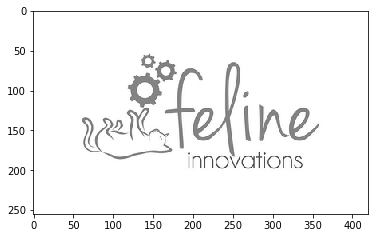

In [9]:
tm_image2_padded = np.pad(tm_image2, ((50,50),(50,50),(0,0)), 'constant', constant_values=(255,255))
print(tm_image2.shape)
print(tm_image2_padded.shape)
imshow(tm_image2_padded)
#print(tm_image2.shape)
#imshow(tm_image2)

In [10]:
print(np.ceil(2.5))

3.0


In [31]:
def half_ceil(x):
    return (np.ceil(x / 2.0)).astype(int)

In [32]:
def half_floor(x):
    return (np.floor(x / 2.0)).astype(int)

In [33]:
def reshape_images_to_same_shape(img1, img2):
    img1_xpad = 0
    img1_ypad = 0
    img2_xpad = 0
    img2_ypad = 0
    
    x_pad = img2.shape[0] - img1.shape[0]
    if (x_pad > 0): #img2 larger in x dim => pad img1
        img1_xpad = x_pad
    else:
        img2_xpad = -x_pad
        
    y_pad = img2.shape[1] - img1.shape[1]
    if (y_pad > 0): #img2 larger in y dim => pad img1
        img1_ypad = y_pad
    else:
        img2_ypad = -y_pad
    
    #img1_pad = np.pad(img1, (((np.ceil(img1_xpad / 2.0).astype(int)), (np.floor(img1_xpad / 2.0).astype(int))),((np.ceil(img1_ypad / 2.0).astype(int)), (np.floor(img1_ypad / 2.0).astype(int))), (0,0)), 'constant', constant_values=(255,255))
    #img2_pad = np.pad(img2, (((np.ceil(img2_xpad / 2.0).astype(int)), (np.floor(img2_xpad / 2.0).astype(int))),((np.ceil(img2_ypad / 2.0).astype(int)), (np.floor(img2_ypad / 2.0).astype(int))), (0,0)), 'constant', constant_values=(255,255))
    
    img1_pad = np.pad(img1, ((half_ceil(img1_xpad), half_floor(img1_xpad)),(half_ceil(img1_ypad), half_floor(img1_ypad)), (0,0)), 'constant', constant_values=(255,255))
    img2_pad = np.pad(img2, ((half_ceil(img2_xpad), half_floor(img2_xpad)),(half_ceil(img2_ypad), half_floor(img2_ypad)), (0,0)), 'constant', constant_values=(255,255))
    
    return(img1_pad, img2_pad)

In [12]:
pimg1, pimg2 = reshape_images_to_same_shape(tm_image, tm_image2)
print(tm_image.shape, pimg1.shape)
print(tm_image2.shape, pimg2.shape)

((260, 260, 3), (260, 320, 3))
((155, 320, 3), (260, 320, 3))


In [13]:
#L1 norm - simple metric for image similarity (http://web.mit.edu/sinhalab/Papers/sinha_russell2011.pdf)
print(np.sum(np.abs(pimg1 - pimg2))) #Not particularly illuminating. [Divide by # pixels to normalize?]

12340902


In [14]:
def calc_L1_dist(img1, img2):
    assert img1.shape == img2.shape, 'Images must have the same shape!'
    return (np.sum(np.abs(img1 - img2))) / (img1.shape[0] * img1.shape[1])

In [15]:
print(calc_L1_dist(pimg1, pimg2))
#Normalized by # of pixels -> value from 0 to 255

148.32814903846153


In [16]:
pimg1_1, pimg1_1 = reshape_images_to_same_shape(tm_image, tm_image)
print(calc_L1_dist(pimg1_1, pimg1_1)) #0, as expected

0.0


(155, 320)


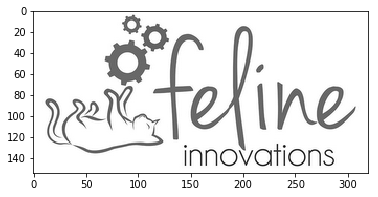

In [17]:
from skimage import io
sk_img = io.imread(url_base2, as_gray=True)
print(sk_img.shape)
imshow(sk_img, cmap='gray')

### Content & Style Similarity (From Style Transfer)

In [18]:
#Most design marks are registered in grayscale... but sometimes color is important
#Convert everything to grayscale for now, but TODO:
#for color registered marks, compare color AS WELL AS grayscale representations

In [19]:
import tensorflow as tf
from nst_utils import *

In [21]:
#Use the VGG model from the original Neural Style Transfer (NST) paper: https://arxiv.org/abs/1508.06576
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")
print(model)

Instructions for updating:
Colocations handled automatically by placer.
{'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>, 'conv5_4': <tf.Tensor 'Relu_15:0' shape=(1, 19, 25, 512) dtype=float32>, 'conv5_1': <tf.Tensor 'Relu_12:0' shape=(1, 19, 25, 512) dtype=float32>, 'conv5_3': <tf.Tensor 'Relu_14:0' shape=(1, 19, 25, 512) dtype=float32>, 'conv5_2': <tf.Tensor 'Relu_13:0' shape=(1, 19, 25, 512) dtype=float32>, 'conv4_4': <tf.Tensor 'Relu_11:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_8:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv4_2': <tf.Tensor 'Relu_9:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv4_3': <tf.Tensor 'Relu_10:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256

In [22]:
def compute_content_cost(a_I, a_C):
    """
    Computes the content cost
    
    Arguments:
    a_I -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image I (input) 
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C (compare)
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_C.get_shape().as_list()
    
    # Reshape a_C and a_G (≈2 lines)
    a_I_unrolled = tf.reshape(a_I, [n_H * n_W, n_C])
    a_C_unrolled = tf.reshape(a_C, [n_H * n_W, n_C])
    
    # compute the cost with tensorflow (≈1 line)
    J_content = (1 / (4 * n_H * n_W * n_C)) * tf.reduce_sum(tf.square(tf.subtract(a_I_unrolled, a_C_unrolled)))
    
    return J_content

In [42]:
def compute_content_cost_diff(sess, img1, img2):
    
    #img1 = reshape_and_normalize_image(img1)
    #img2 = reshape_and_normalize_image(img2)

    sess.run(model['input'].assign(img1))
    out = model['conv4_2']
    a_I = sess.run(out)

    sess.run(model['input'].assign(img2))
    out = model['conv4_2']
    a_C = sess.run(out)

    # Compute the content cost
    return compute_content_cost(a_I, a_C)

In [34]:
def pad_to_300_400(img):
    img_xpad = 300 - img.shape[0]
    img_ypad = 400 -img.shape[1]
    img_pad = np.pad(img, ((half_ceil(img_xpad), half_floor(img_xpad)),(half_ceil(img_ypad), half_floor(img_ypad)), (0,0)), 'constant', constant_values=(255,255))
    return img_pad

In [36]:
test_imgx = reshape_and_normalize_image(pad_to_300_400(tm_image))
print(tm_image.shape, test_imgx.shape)

((260, 260, 3), (1, 300, 400, 3))


In [37]:
test_imgx2 = reshape_and_normalize_image(pad_to_300_400(tm_image2))
print(tm_image2.shape, test_imgx2.shape)

((155, 320, 3), (1, 300, 400, 3))


In [50]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #print(compute_content_cost_diff(sess, test_imgx, test_imgx2))
    sess.run(model['input'].assign(test_imgx))
    out = model['conv4_2']
    a_I = sess.run(out)
    print(a_I)

ValueError: Fetch argument <tf.Tensor 'Assign_12:0' shape=(1, 300, 400, 3) dtype=float32_ref> cannot be interpreted as a Tensor. (Tensor Tensor("Assign_12:0", shape=(1, 300, 400, 3), dtype=float32_ref) is not an element of this graph.)